In [680]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import re

In [681]:
df1 = pd.read_json(
    "res_data.json",
    orient="records"
)
df1.columns

Index(['title', 'text', 'source', 'title_words', 'text_words', 'sentiment',
       'keyword', 'word_map'],
      dtype='object')

In [747]:
df1.shape

(3489, 6)

In [682]:

df1 = df1[[
    'title', 
    'text', 
    'title_words', 
    'text_words', 
    'sentiment',
    'word_map'
]]



In [683]:
df1.head()

,title,text,title_words,text_words,sentiment,word_map
0,разблокировка карты после удаления из ркл,здравствуйте меня по ошибке добавили в реестр ...,"['разблокировка', 'карты', 'после', 'удаления'...","['здравствуйте', 'меня', 'по', 'ошибке', 'доба...",1,"{'разблокировка': '1', 'карты': '1', 'после': ..."
1,консультация по минимальной сумме покупок в ме...,22 мая в онлайнчате я консультировался по пово...,"['консультация', 'по', 'минимальной', 'сумме',...","['22', 'мая', 'в', 'онлайнчате', 'я', 'консуль...",0,"{'консультация': '1', 'по': '2', 'минимальной'..."
2,пригласи друга,5 апреля пригласил друга по реферальной ссылке...,"['пригласи', 'друга']","['5', 'апреля', 'пригласил', 'друга', 'по', 'р...",-1,"{'пригласи': '1', 'друга': '2', '5': '1', 'апр..."
3,оформление дебетовой карты,приехал представитель газпромбанка 10 мая 2025...,"['оформление', 'дебетовой', 'карты']","['приехал', 'представитель', 'газпромбанка', '...",1,"{'оформление': '1', 'дебетовой': '1', 'карты':..."
4,спасибо за качественное обслуживание,сделала заявку на сайте все было понятно и про...,"['спасибо', 'за', 'качественное', 'обслуживание']","['сделала', 'заявку', 'на', 'сайте', 'все', 'б...",1,"{'спасибо': '1', 'качество': '1', 'обслуживани..."


In [684]:
from collections import Counter, defaultdict

def create_map_custom(row):
    all_words = row['title_words'] + row['text_words']
    row["word_map"] = defaultdict(int)
    for word in all_words:
        row["word_map"][word] += 1
    row["word_map"] = dict(row["word_map"])
    return row



In [685]:
import json

In [686]:
neutral_df = pd.read_json("neutral_res.json", orient="records")[[
    'title', 
    'text', 
    'title_words', 
    'text_words', 
    'sentiment',
    'word_map'
]]


def parse_word_string(s):
    """Парсит строку вида "['word1', 'word2', 'word3']" в список"""
    if isinstance(s, list):
        return s
    if not isinstance(s, str):
        return []
    
    s = s.strip()
    if s.startswith('[') and s.endswith(']'):
        s = s[1:-1]
    

    words = [word.strip().strip("'\"") for word in s.split(',') if word.strip()]
    return words

def create_map(row):
    try:
        title_words = parse_word_string(row['title_words'])
        text_words = parse_word_string(row['text_words'])
        
        row["word_map"] = dict(Counter(title_words + text_words))
        
    except Exception as e:
        print(f"Ошибка в строке: {e}")
        row["word_map"] = {}
    
    return row

neutral_df = neutral_df.apply(create_map, axis=1)




In [687]:
neutral_df.head()

,title,text,title_words,text_words,sentiment,word_map
0,не получалось войти в приложение,получила карту газпромбанка в декабре 2024г но...,"['не', 'получалось', 'войти', 'в', 'приложение']","['получила', 'карту', 'газпромбанка', 'в', 'де...",0,"{'не': 2, 'получалось': 1, 'войти': 1, 'в': 4,..."
1,получение дебетовой карты,были проблемы с переводом по сбп невозможно бы...,"['получение', 'дебетовой', 'карты']","['были', 'проблемы', 'с', 'переводом', 'по', '...",0,"{'получение': 1, 'дебетовой': 1, 'карты': 1, '..."
2,небольшие проблемы с переводом,ситуация следующая я попытался совершить перев...,"['небольшие', 'проблемы', 'с', 'переводом']","['ситуация', 'следующая', 'я', 'попытался', 'с...",0,"{'небольшие': 1, 'проблемы': 1, 'с': 1, 'перев..."
3,спасибо,оформил дебетовую карту с привилегиями плюс у...,['спасибо'],"['оформил', 'дебетовую', 'карту', 'с', 'привил...",0,"{'спасибо': 1, 'оформил': 1, 'дебетовую': 1, '..."
4,пытаются помочь,здравствуйте обращалась позавчера на горячую л...,"['пытаются', 'помочь']","['здравствуйте', 'обращалась', 'позавчера', 'н...",0,"{'пытаются': 1, 'помочь': 1, 'здравствуйте': 1..."


In [688]:


df = pd.concat((
    neutral_df, 
    df1
), copy=True)


In [689]:
import ast

def parse_list_column(df: pd.DataFrame, columns) -> pd.DataFrame:
    """
    Преобразует строковые представления списков в колонке в настоящие списки.
    """
    for column in columns:
        df[column] = df[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    return df

In [ ]:
df = parse_list_column(
    df,
    [
        "title_words",
        "text_words",
    ]
)

In [691]:
df.head()

,title,text,title_words,text_words,sentiment,word_map
0,не получалось войти в приложение,получила карту газпромбанка в декабре 2024г но...,"[не, получалось, войти, в, приложение]","[получила, карту, газпромбанка, в, декабре, 20...",0,"{'не': 2, 'получалось': 1, 'войти': 1, 'в': 4,..."
1,получение дебетовой карты,были проблемы с переводом по сбп невозможно бы...,"[получение, дебетовой, карты]","[были, проблемы, с, переводом, по, сбп, невозм...",0,"{'получение': 1, 'дебетовой': 1, 'карты': 1, '..."
2,небольшие проблемы с переводом,ситуация следующая я попытался совершить перев...,"[небольшие, проблемы, с, переводом]","[ситуация, следующая, я, попытался, совершить,...",0,"{'небольшие': 1, 'проблемы': 1, 'с': 1, 'перев..."
3,спасибо,оформил дебетовую карту с привилегиями плюс у...,[спасибо],"[оформил, дебетовую, карту, с, привилегиями, п...",0,"{'спасибо': 1, 'оформил': 1, 'дебетовую': 1, '..."
4,пытаются помочь,здравствуйте обращалась позавчера на горячую л...,"[пытаются, помочь]","[здравствуйте, обращалась, позавчера, на, горя...",0,"{'пытаются': 1, 'помочь': 1, 'здравствуйте': 1..."


In [692]:
negative = df[df.sentiment == -1]
positive = df[df.sentiment == 1]
neutral = df[df.sentiment == 0]

In [693]:
from collections import defaultdict

In [694]:
def count_caps(df):
    counter = {
        "words": 0,
        "starts_with_caps": 0,
        "starts_with_caps_ratio": 0.0,
        "full_caps": 0,
        "full_caps_ratio": 0.0,
    }

    for _, row in df.iterrows():
        title_words = row.get("title_words", [])
        text_words = row.get("text_words", [])
        words = title_words + text_words

        for word in words:
            if not word:
                continue
            counter["words"] += 1
            if word[0].isupper():
                counter["starts_with_caps"] += 1
            if word.isupper() and len(word) > 1:  # часто капс — 2+ буквы
                counter["full_caps"] += 1

    total_words = counter["words"] if counter["words"] > 0 else 1
    counter["starts_with_caps_ratio"] = counter["starts_with_caps"] / total_words
    counter["full_caps_ratio"] = counter["full_caps"] / total_words

    return counter

In [695]:
from collections import Counter, defaultdict
import pandas as pd

def get_overall_word_frequencies(df, word_map_column='word_map'):
    """
    Подсчитывает общую частоту слов по всему датафрейму
    """
    overall_counter = Counter()
    
    for word_map in df[word_map_column]:
        if isinstance(word_map, dict):
            for key, value in word_map.items():
                # Преобразуем ключ в строку, значение в int
                key_str = str(key)
                try:
                    # Пробуем преобразовать значение в число
                    if isinstance(value, (int, float)):
                        count = int(value)
                    elif isinstance(value, str):
                        count = int(float(value))  # на случай если строка с числом
                    else:
                        count = 0
                    overall_counter[key_str] += count
                except (ValueError, TypeError):
                    # Если не получается преобразовать, игнорируем
                    continue
    
    return overall_counter

def get_top_words(df, word_map_column='word_map', top_n=20):
    """
    Возвращает топ-N самых частых слов
    """
    overall_counter = get_overall_word_frequencies(df, word_map_column)
    return overall_counter.most_common(top_n)

def get_word_frequency_stats(df, word_map_column='word_map'):
    """
    Возвращает статистику по частотам слов
    """
    overall_counter = get_overall_word_frequencies(df, word_map_column)
    
    if not overall_counter:
        return {}
    
    total_words = sum(overall_counter.values())
    unique_words = len(overall_counter)
    
    return {
        'total_words': total_words,
        'unique_words': unique_words,
        'avg_frequency': total_words / unique_words if unique_words > 0 else 0,
        'top_10_words': overall_counter.most_common(10)
    }

In [696]:
from pprint import pprint

In [697]:
def get_over_threshold(glos: dict, threshold: int):
    res = {}
    for key, value in glos.items():
        try:
            value_int = int(value)
            if value_int >= threshold:
                res[key] = value_int
        except Exception as e:
            print(f"Exception for key '{key}', value '{value}': {e}")
            continue
    return res

In [698]:
neg_freq = get_overall_word_frequencies(negative)
neg_freq = dict(sorted(neg_freq.items(), key=lambda x: x[1], reverse=True))
thresholded = get_over_threshold(neg_freq, 5)
thresholded = dict(sorted(thresholded.items(), key=lambda x: x[1], reverse=True))
print(thresholded)

{'в': 2451, 'и': 2034, 'не': 1817, 'на': 1444, 'по': 1112, 'с': 893, 'я': 888, 'что': 819, 'банк': 729, 'за': 639, 'карту': 601, 'банка': 558, 'карты': 485, 'карта': 437, 'деньги': 354, 'но': 342, 'при': 339, 'мне': 337, 'как': 297, 'газпромбанк': 288, 'все': 286, 'для': 266, 'газпромбанка': 263, 'через': 257, 'акции': 252, 'до': 250, 'день': 234, 'рублей': 233, 'у': 232, 'без': 228, 'меня': 224, 'а': 223, 'о': 217, 'дебетовую': 215, 'это': 213, 'так': 207, 'условия': 203, 'от': 203, 'было': 194, 'к': 188, 'чате': 184, 'карте': 179, 'нет': 175, 'года': 173, 'была': 173, 'после': 164, 'премиум': 161, 'уже': 157, 'обман': 155, 'счет': 148, 'кредитной': 147, 'обслуживание': 145, 'приложении': 142, 'чат': 142, 'банке': 139, '2024': 139, 'добрый': 135, 'руб': 134, 'привилегии': 133, 'только': 127, 'был': 126, 'из': 125, '5000': 125, 'чтобы': 124, 'кэшбэк': 124, 'кредитную': 122, 'дней': 119, 'счета': 117, 'приложение': 116, 'месяц': 114, 'если': 112, 'клиентом': 111, 'отделение': 110, 'раз'

In [699]:
negative_words = [
    'ужасный',
    'ужасное',
    'отвратительное',
    'отвратительный',
    'худший',
    'проблемы',
    'проблема',
    'невозможно',
    'никогда',
    'обманщики',
    'навязывание',
    'отказ',
    'ожидание',
    'ожидания',
    'заблокировали',
    'заблокировал',
    'жать',
    'пытался',
    'очередь',
    'очереди'
    'пришлось',
    'якобы',
    'бот',
    'заняты',
    'отсутствие',
]

In [700]:
negative_bank_words = {
    # Общее недовольство
    'ужасный', 'кошмарный', 'отвратительный', 'худший', 'позорный', 'невыносимый',
    'ужасно', 'кошмарно', 'отвратительно', 'позорно', 'невыносимо',
    
    # Проблемы с обслуживанием
    'невозможно', 'бесполезный', 'безответственный', 'некомпетентный', 'непрофессиональный',
    'хамский', 'грубый', 'невнимательный', 'равнодушный', 'невежливый',
    
    # Мошенничество и обман
    'обман', 'мошенничество', 'развод', 'кидалово', 'наебалово', 'лохотрон',
    'обманули', 'кинули', 'надурили', 'обворовали', 'ограбили',
    
    # Технические проблемы
    'глючный', 'бажный', 'неработающий', 'сбоит', 'висит', 'лагает',
    'недоступен', 'нефункциональный', 'кривой', 'сырой',
    
    # Деньги и списания
    'списали', 'украли', 'содрали', 'сняли', 'обокрали', 'обчистили', 'штраф', 'пеня', 'незаконное',
    
    # Время и ожидание
    'долго', 'медленно', 'вечность', 'задержка', 'простой', 'ожидание',
    'завис', 'тормозит', 'недождался', 'пропало',
    
    # Связь и поддержка
    'недозвониться', 'неотвечают', 'игнорируют', 'бросили', 'бросил',
    'бот', 'автоответчик', 'непонятно', 'неясно',
    
    # Блокировки и ограничения
    'заблокировали', 'заблокирован', 'блокировка', 'ограничили', 'заморозили',
    'отказали', 'отказ', 'запретили',
    
    # Эмоции и чувства
    'разочарован', 'возмущен', 'взбешен', 'яростный', 'бесит', 'бесило',
    'злюсь', 'нервы', 'стресс', 'истерика',
    
    # Качество услуг
    'некачественный', 'отстойный', 'говняный', 'дерьмовый', 'паршивый',
    'низкосортный', 'недоделанный', 'кустарный',
    
    # Доверие
    'ненадежный', 'рискованный', 'опасный', 'сомнительный', 'подозрительный',
    'недоверие', 'сомнение', 'опаска',
    
    # Процессы и процедуры
    'бюрократия', 'волокита', 'беготня', 'мытарство', 'запутанный',
    'сложный', 'замороченный', 'геморройный',
    
    # Репутация
    'позор', 'стыд', 'срам', 'дикость', 'беспредел', 'произвол',
    'беззаконие', 'беспорядок', 'хаос',
    
    # Последствия
    'потерял', 'лишился', 'пострадал', 'убытки', 'ущерб', 'вред',
    'проблемы', 'неприятности', 'сложности',
    
    # Отношения
    'предательство', 'измена', 'обманщики', 'вруны', 'лжецы', 'лицемеры',
    'продажный', 'коррумпированный',
    
    # Безвыходность
    'безвыходный', 'тупиковый', 'безнадежный', 'бесперспективный',
    'загнанный', 'заложник', 'зависимость',
    
    # Сравнения
    'хуже', 'наихудший', 'наипозорнейший', 'предельный',
    'днище', 'дно', 'днобанк',
    
    # Советы другим
    'нерекомендую', 'бегите', 'остерегайтесь', 'избегайте', 'осторожно',
    'опасно', 'несвязывайтесь',
    
    # Время и сроки
    'просрочка', 'запаздывание', 'опоздание', 'нарушение',
    'невыполнение', 'сорвано', 'провал',
    
    # Дополнительные эмоциональные
    'шокирован', 'ошеломлен', 'потрясен', 'впал', 'впала',
    'депрессия', 'отчаяние', 'безысходность',
    
    # Конкретные банковские проблемы
    'просроченный', 'просрочка', 'задолженность', 'долг',
    'коллекторы', 'взыскание', 'приставы',
    
    # Интернет-банкинг
    'упал', 'лежит', 'недоступность', 'отвал', 'отвалился',
    'отключили', 'отрубили', 'отказ'
}

negative_words = {
    # общее недовольство
    "плохо", "ужасно", "отвратительно", "кошмар", "неприятно", "худший", "ужас", "отстой",
    "разочарование", "разочарован", "разочарована", "просто жесть", "безобразие", "позор",
    "стыд", "стыдно", "бред", "абсурд", "жесть", "мрак", "шок", "отврат", "стыдоба",

    # мошенничество / обман
    "обман", "мошенничество", "мошенники", "вымогательство", "вымогают", "обманули",
    "развод", "развели", "обвели", "враньё", "врут", "лгут", "неправда", "вранье",

    # отказ, не работает, сбои
    "отказ", "отказали", "отказано", "не работает", "не запускается", "не грузится",
    "зависает", "вылетает", "сломалось", "сломано", "ошибка", "ошибки", "сбой", "сбои",
    "не загружается", "недоступно", "отваливается", "не отвечает", "не реагирует",

    # интерфейс / приложение
    "глючит", "глючное", "тормозит", "тупит", "непонятно", "неудобно", "нелогично",
    "непродуманно", "устаревший", "сложно", "запутанно", "неинтуитивно", "криво",
    "древний интерфейс", "костыльно", "некомфортно", "неюзабельно",

    # поддержка / операторы
    "хамство", "грубо", "грубость", "хамы", "нагрубили", "игнор", "игнорируют",
    "не отвечают", "не перезванивают", "перекидывают", "переводят по кругу",
    "не помогли", "не решили", "отмахнулись", "промолчали", "саботаж",

    # финансы / карты
    "пропали деньги", "списали деньги", "потеря средств", "потеря денег",
    "украли деньги", "деньги не пришли", "не зачислили", "не вернули", "задержка перевода",
    "блокировка счета", "заморозили", "арестовали", "нет доступа", "недоступен счёт",
    "не работает карта", "карта заблокирована", "блокнули", "карта не читается",
    "сняли комиссию", "скрытая комиссия", "необоснованная комиссия",

    # вход / безопасность / идентификация
    "не могу войти", "не входит", "не пускает", "заблокирован", "заблокировали",
    "не прошёл проверку", "не прошел верификацию", "отказ в доступе", "ограничение доступа",
    "недопуск", "сбой авторизации", "проблема с входом", "доступ запрещён",
    "доступ ограничен", "долгая проверка", "бесконечная проверка",

    # скорость / время
    "долго", "очень долго", "вечно", "сутками", "часами", "долгий ответ", "медленно",
    "вечно ждёшь", "время тянут", "оттягивают", "медлительность", "нет реакции",
    "тянули резину", "долгий процесс", "задержка", "просрочка", "опоздание", "задерживают",


    # немного токсичности (если будешь очищать текст)
    "дебилы", "уроды", "гандоны", "мрази", "скоты", "ублюдки", "придурки", "говнобанк",
    "говно", "конченые", "твари", "нелюди", "мудаки", "херня", "говносервис", "скотство"
}

negative_words = negative_words.union(negative_bank_words)

In [701]:
negative_words

{'абсурд',
 'автоответчик',
 'арестовали',
 'бажный',
 'бегите',
 'беготня',
 'безвыходный',
 'беззаконие',
 'безнадежный',
 'безобразие',
 'безответственный',
 'безысходность',
 'бесило',
 'бесит',
 'бесконечная проверка',
 'бесперспективный',
 'бесполезный',
 'беспорядок',
 'беспредел',
 'блокировка',
 'блокировка счета',
 'блокнули',
 'бот',
 'бред',
 'бросил',
 'бросили',
 'бюрократия',
 'вечно',
 'вечно ждёшь',
 'вечность',
 'взбешен',
 'взыскание',
 'висит',
 'возмущен',
 'волокита',
 'впал',
 'впала',
 'вранье',
 'враньё',
 'вред',
 'время тянут',
 'вруны',
 'врут',
 'вылетает',
 'вымогательство',
 'вымогают',
 'гандоны',
 'геморройный',
 'глючит',
 'глючное',
 'глючный',
 'говно',
 'говнобанк',
 'говносервис',
 'говняный',
 'грубо',
 'грубость',
 'грубый',
 'дебилы',
 'деньги не пришли',
 'депрессия',
 'дерьмовый',
 'дикость',
 'днище',
 'дно',
 'днобанк',
 'долг',
 'долгая проверка',
 'долгий ответ',
 'долгий процесс',
 'долго',
 'доступ запрещён',
 'доступ ограничен',
 'древн

In [702]:
pos_freq = get_overall_word_frequencies(positive)
pos_freq = dict(sorted(pos_freq.items(), key=lambda x: x[1], reverse=True))
thresholded = get_over_threshold(pos_freq, 5)
thresholded = dict(sorted(thresholded.items(), key=lambda x: x[1], reverse=True))
print(thresholded)

{'и': 2525, 'в': 1792, 'на': 1238, 'по': 774, 'с': 733, 'я': 723, 'не': 596, 'карта': 496, 'банка': 468, 'что': 460, 'все': 458, 'за': 441, 'мне': 416, 'карты': 393, 'карту': 359, 'газпромбанка': 329, 'для': 292, 'меня': 290, 'как': 281, 'о': 273, 'банк': 243, 'очень': 243, 'быстро': 242, 'время': 221, 'от': 216, 'но': 212, 'а': 196, 'представитель': 190, 'у': 190, 'благодарность': 180, 'ипотека': 180, 'условия': 174, 'уже': 170, 'спасибо': 168, 'так': 168, 'дебетовую': 165, 'газпромбанк': 161, 'решил': 158, 'было': 156, 'без': 156, 'день': 152, 'к': 149, 'через': 147, 'дебетовой': 144, 'это': 131, 'обслуживание': 129, 'заявку': 127, 'вс': 127, 'можно': 126, 'до': 125, 'оформить': 124, 'сразу': 117, 'хочу': 115, 'сотрудник': 114, 'при': 114, 'деньги': 113, 'ипотеку': 113, 'про': 112, 'была': 112, 'со': 111, 'еще': 108, 'ставка': 107, 'нет': 104, 'года': 98, 'рассказал': 98, 'рублей': 97, 'здесь': 97, 'лет': 96, 'газпромбанке': 95, 'есть': 94, 'чтобы': 92, 'был': 91, 'мы': 89, 'банке': 

In [703]:
from typing import Union

def count_negative_words(row):

    glos = {
        'абсурд',
        'автоответчик',
        'арестовали',
        'бажный',
        'бегите',
        'беготня',
        'безвыходный',
        'беззаконие',
        'безнадежный',
        'безобразие',
        'безответственный',
        'безысходность',
        'бесило',
        'бесит',
        'бесконечная проверка',
        'бесперспективный',
        'бесполезный',
        'беспорядок',
        'беспредел',
        'блокировка',
        'блокировка счета',
        'блокнули',
        'бот',
        'бред',
        'бросил',
        'бросили',
        'бюрократия',
        'вечно',
        'вечно ждёшь',
        'вечность',
        'взбешен',
        'взыскание',
        'висит',
        'возмущен',
        'волокита',
        'впал',
        'впала',
        'вранье',
        'враньё',
        'вред',
        'время тянут',
        'вруны',
        'врут',
        'вылетает',
        'вымогательство',
        'вымогают',
        'гандоны',
        'геморройный',
        'глючит',
        'глючное',
        'глючный',
        'говно',
        'говнобанк',
        'говносервис',
        'говняный',
        'грубо',
        'грубость',
        'грубый',
        'дебилы',
        'деньги не пришли',
        'депрессия',
        'дерьмовый',
        'дикость',
        'днище',
        'дно',
        'днобанк',
        'долг',
        'долгая проверка',
        'долгий ответ',
        'долгий процесс',
        'доступ запрещён',
        'доступ ограничен',
        'древний интерфейс',
        'жесть',
        'заблокировали',
        'заблокирован',
        'завис',
        'зависает',
        'зависимость',
        'загнанный',
        'задерживают',
        'задержка',
        'задержка перевода',
        'задолженность',
        'заложник',
        'заморозили',
        'замороченный',
        'запаздывание',
        'запретили',
        'запутанно',
        'запутанный',
        'злюсь',
        'игнор',
        'игнорируют',
        'избегайте',
        'измена',
        'истерика',
        'карта заблокирована',
        'карта не читается',
        'кидалово',
        'кинули',
        'коллекторы',
        'конченые',
        'коррумпированный',
        'костыльно',
        'кошмар',
        'кошмарно',
        'кошмарный',
        'криво',
        'кривой',
        'кустарный',
        'лагает',
        'лгут',
        'лежит',
        'лжецы',
        'лицемеры',
        'лишился',
        'лохотрон',
        'медленно',
        'медлительность',
        'мошенники',
        'мошенничество',
        'мрази',
        'мрак',
        'мудаки',
        'мытарство',
        'нагрубили',
        'надурили',
        'наебалово',
        'наипозорнейший',
        'наихудший',
        'нарушение',
        'не вернули',
        'не входит',
        'не грузится',
        'не загружается',
        'не запускается',
        'не зачислили',
        'не могу войти',
        'не отвечает',
        'не отвечают',
        'не перезванивают',
        'не помогли',
        'не прошел верификацию',
        'не прошёл проверку',
        'не пускает',
        'не работает',
        'не работает карта',
        'не реагирует',
        'не решили',
        'невежливый',
        'невнимательный',
        'невозможно',
        'невыносимо',
        'невыносимый',
        'невыполнение',
        'недоверие',
        'недоделанный',
        'недождался',
        'недозвониться',
        'недопуск',
        'недоступен',
        'недоступен счёт',
        'недоступно',
        'недоступность',
        'незаконное',
        'неинтуитивно',
        'некачественный',
        'некомпетентный',
        'некомфортно',
        'нелогично',
        'нелюди',
        'ненадежный',
        'необоснованная комиссия',
        'неотвечают',
        'непонятно',
        'неправда',
        'неприятно',
        'неприятности',
        'непродуманно',
        'непрофессиональный',
        'неработающий',
        'нервы',
        'нерекомендую',
        'несвязывайтесь',
        'нет доступа',
        'нет реакции',
        'неудобно',
        'нефункциональный',
        'неюзабельно',
        'неясно',
        'низкосортный',
        'обвели',
        'обворовали',
        'обман',
        'обманули',
        'обманщики',
        'обокрали',
        'обчистили',
        'ограбили',
        'ограничение доступа',
        'ограничили',
        'ожидание',
        'опаска',
        'опасно',
        'опасный',
        'опоздание',
        'остерегайтесь',
        'осторожно',
        'отвал',
        'отваливается',
        'отвалился',
        'отврат',
        'отвратительно',
        'отвратительный',
        'отказ',
        'отказ в доступе',
        'отказали',
        'отказано',
        'отключили',
        'отмахнулись',
        'отрубили',
        'отстой',

        'очередь',
        'долго',
        'прождал',
        'ожидание',
        'проторчал',


        'отстой',
        'отстойный',
        'оттягивают',
        'отчаяние',
        'очень долго',
        'ошеломлен',
        'ошибка',
        'ошибки',
        'паршивый',
        'пеня',
        'переводят по кругу',
        'перекидывают',
        'плохо',
        'подозрительный',
        'позор',
        'позорно',
        'позорный',
        'пострадал',
        'потеря денег',
        'потеря средств',
        'потерял',
        'потрясен',
        'предательство',
        'предельный',
        'придурки',
        'приставы',
        'проблема с входом',
        'проблемы',
        'провал',
        'продажный',
        'произвол',
        'промолчали',
        'пропали деньги',
        'пропало',
        'просроченный',
        'просрочка',
        'просто жесть',
        'простой',
        'равнодушный',
        'развели',
        'развод',
        'разочарован',
        'разочарована',
        'разочарование',
        'рискованный',
        'саботаж',
        'сбои',
        'сбоит',
        'сбой',
        'сбой авторизации',
        'скотство',
        'скоты',
        'скрытая комиссия',
        'сложно',
        'сложности',
        'сложный',
        'сломалось',
        'сломано',
        'сняли',
        'сняли комиссию',
        'содрали',
        'сомнение',
        'сомнительный',
        'сорвано',
        'списали',
        'списали деньги',
        'срам',
        'стресс',
        'стыд',
        'стыдно',
        'стыдоба',
        'сутками',
        'сырой',
        'твари',
        'тормозит',
        'тупиковый',
        'тупит',
        'тянули резину',
        'ублюдки',
        'убытки',
        'ужас',
        'ужасно',
        'ужасный',
        'украли',
        'украли деньги',
        'упал',
        'уроды',
        'устаревший',
        'ущерб',
        'хамский',
        'хамство',
        'хамы',
        'хаос',
        'херня',
        'худший',
        'хуже',
        'часами',
        'шок',
        'шокирован',
        'штраф',
        'яростный'
        'проторчала',
        'проторчал'
    }

    row["negative_counter"] = 0


    def parse_words(x):
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except:
                return []
        return x if isinstance(x, list) else []

    title_words = parse_words(row.get("title_words"))
    text_words = parse_words(row.get("text_words"))
    all_words = title_words + text_words

    # Считаем совпадения
    for word in all_words:
        if word.lower() in glos:
            row["negative_counter"] += 1

    return row

In [704]:
df = df.apply(
    count_negative_words,
    axis=1
)


In [705]:
(df[df.sentiment == -1].negative_counter).sum()

np.int64(1187)

In [706]:
(df[df.sentiment == 0].negative_counter).sum()

np.int64(52)

In [707]:
(df[df.sentiment == 1].negative_counter).sum()

np.int64(104)

In [708]:
df_pos = df[df.sentiment == 1]

In [709]:
df_pos.head()

,title,text,title_words,text_words,sentiment,word_map,negative_counter
0,разблокировка карты после удаления из ркл,здравствуйте меня по ошибке добавили в реестр ...,"[разблокировка, карты, после, удаления, из, ркл]","[здравствуйте, меня, по, ошибке, добавили, в, ...",1,"{'разблокировка': '1', 'карты': '1', 'после': ...",1
3,оформление дебетовой карты,приехал представитель газпромбанка 10 мая 2025...,"[оформление, дебетовой, карты]","[приехал, представитель, газпромбанка, 10, мая...",1,"{'оформление': '1', 'дебетовой': '1', 'карты':...",0
4,спасибо за качественное обслуживание,сделала заявку на сайте все было понятно и про...,"[спасибо, за, качественное, обслуживание]","[сделала, заявку, на, сайте, все, было, понятн...",1,"{'спасибо': '1', 'качество': '1', 'обслуживани...",0
5,дебетовая карта,15072025 заказала вечером карту дебетовую на д...,"[дебетовая, карта]","[15072025, заказала, вечером, карту, дебетовую...",1,"{'дебетовая': '1', 'карта': '1', 'заказала': '...",0
6,клиентоориентированные сотрудники,посетила офис с целью снять денежные средства ...,"[клиентоориентированные, сотрудники]","[посетила, офис, с, целью, снять, денежные, ср...",1,"{'клиентоориентированные': '1', 'сотрудники': ...",0


In [710]:
type(df_pos.loc[0, 'text_words'])

list

In [711]:
from collections import Counter

def find_suspect_negative_words_full(df, negative_words: set) -> dict:

    counter = Counter()

    for _, row in df.iterrows():
        words = row.get('title_words', []) + row.get('text_words', [])
        for word in words:
            if word in negative_words:
                counter[word] += 1

    return dict(counter)

In [712]:
result = find_suspect_negative_words_full(df=df_pos, negative_words=negative_words)

In [713]:
print("Всего негативных слов в позитивных отзывах:", sum(result.values()))

Всего негативных слов в позитивных отзывах: 89


In [714]:
find_suspect_negative_words_full(df=df_pos, negative_words=negative_words)

{'ошибка': 4,
 'ожидание': 6,
 'отказ': 1,
 'хуже': 1,
 'долго': 21,
 'простой': 4,
 'невозможно': 2,
 'мошенники': 1,
 'лежит': 2,
 'проблемы': 16,
 'долг': 2,
 'бот': 5,
 'списали': 4,
 'сняли': 2,
 'заблокировали': 2,
 'неудобно': 6,
 'отключили': 2,
 'отказали': 1,
 'надурили': 1,
 'обман': 1,
 'ошибки': 1,
 'обманули': 1,
 'глючный': 1,
 'нервы': 1,
 'плохо': 1}

In [715]:
df_neg = df[df["sentiment"] == -1]

In [716]:
find_suspect_negative_words_full(df=df_neg, negative_words=negative_words)["долго"]

24

In [717]:
df["negative_ratio"] = 100*df.negative_counter / len(df.text_words + df.title_words)

### Строим модель

In [718]:
df["all_words"] = df["title_words"].apply(lambda x: ' '.join(x)) + ' ' + df["text_words"].apply(lambda x: ' '.join(x))

In [719]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


X = df[["all_words", "negative_counter", "negative_ratio"]]
y = df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


preprocessor = ColumnTransformer(transformers=[
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=5), "all_words"),
    ("scaler", StandardScaler(), ["negative_counter", "negative_ratio"]),
])



In [720]:
pipeline_1 = Pipeline([
    ("features", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced")),
])

pipeline_1.fit(X_train, y_train)

y_pred = pipeline_1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.85      0.86       484
           0       0.27      0.30      0.28        76
           1       0.86      0.85      0.85       355

    accuracy                           0.80       915
   macro avg       0.66      0.67      0.66       915
weighted avg       0.81      0.80      0.81       915



In [721]:
from catboost import CatBoostClassifier

pipeline_2 = Pipeline([
    ("features", preprocessor),
    ("clf", CatBoostClassifier(verbose=0, random_state=42, auto_class_weights="Balanced")),
])

In [722]:
pipeline_2.fit(X_train, y_train)

y_pred = pipeline_2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.89      0.87       484
           0       0.29      0.24      0.26        76
           1       0.85      0.84      0.85       355

    accuracy                           0.82       915
   macro avg       0.67      0.66      0.66       915
weighted avg       0.81      0.82      0.81       915



### Выбрали модель, теперь улучшаем

In [723]:
X = df[["all_words", "negative_counter", "negative_ratio"]]
y = df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


preprocessor = ColumnTransformer(transformers=[
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=5), "all_words"),
    ("scaler", StandardScaler(), ["negative_counter", "negative_ratio"]),
])

pipeline = Pipeline([
    ("features", preprocessor),
    ("clf", CatBoostClassifier(verbose=0, random_state=42, auto_class_weights="Balanced")),
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.89      0.87       484
           0       0.29      0.24      0.26        76
           1       0.85      0.84      0.85       355

    accuracy                           0.82       915
   macro avg       0.67      0.66      0.66       915
weighted avg       0.81      0.82      0.81       915



In [724]:
negative = df[df.sentiment == -1]
positive = df[df.sentiment == 1]
neutral = df[df.sentiment == 0]

In [725]:
neutral_freq = get_overall_word_frequencies(neutral)
neutral_freq = dict(sorted(neutral_freq.items(), key=lambda x: x[1], reverse=True))
thresholded = get_over_threshold(neutral_freq, 10)
thresholded = dict(sorted(thresholded.items(), key=lambda x: x[1], reverse=True))
print(thresholded)

{'в': 539, 'и': 272, 'на': 259, 'по': 215, 'не': 188, 'я': 174, 'с': 161, 'что': 113, 'за': 103, 'банка': 94, 'карту': 87, 'карты': 86, 'газпромбанка': 73, 'для': 70, 'акции': 69, 'но': 68, 'как': 67, 'мне': 65, 'банк': 57, 'меня': 55, 'о': 54, 'было': 50, 'через': 47, 'карта': 43, 'день': 40, 'у': 39, 'к': 39, 'газпромбанк': 39, 'чат': 38, 'приложении': 37, 'так': 35, 'а': 35, 'от': 35, 'до': 35, 'все': 32, 'года': 32, 'условия': 31, 'гпб': 31, 'обратилась': 30, 'вопрос': 30, 'при': 28, 'быстро': 28, 'здравствуйте': 26, 'время': 25, 'дебетовую': 25, '35': 25, 'кешбэк': 25, 'карте': 25, 'ли': 24, 'это': 24, 'счета': 24, 'была': 23, 'же': 23, 'решил': 23, 'уже': 23, 'нужно': 22, 'дебетовой': 22, 'кредитной': 22, 'оператор': 21, 'был': 21, 'после': 21, 'чате': 21, 'можно': 21, 'руб': 21, 'покупки': 21, 'есть': 20, 'чтобы': 20, 'деньги': 19, 'ответили': 19, 'банке': 19, 'приложение': 18, 'были': 18, 'когда': 18, 'сегодня': 18, 'офис': 18, 'акция': 18, 'из': 18, 'минут': 18, 'хочу': 18, 'о

In [726]:
neutral_words = {
    'оформление', 'регистрация', 'заявка', 'документы', 'карта', 'получил', 'открыл', 
    'отделение', 'процесс', 'услуга', 'предоставление', 'подключил', 'перевод', 'зачисление',
    'снятие', 'платеж', 'транзакция', 'вход', 'выход', 'возможность', 'доступ', 
    'активация', 'обновление', 'информация', 'сайт', 'интерфейс', 'приложение',
    'поддержка', 'чат', 'обращение', 'обслуживание', 'пользуюсь', 'использую', 
    'удобство', 'работает', 'проверка', 'отправка', 'ожидание', 'получение', 'выпуск',
    'первый', 'второй', 'время', 'номер', 'сумма', 'дата', 'период', 'сообщение',
    'сессия', 'тест', 'вопрос', 'ответ', 'всё', 'все', 'нормально', 'штатно', 
    'по плану', 'ожидаемо', 'ничего особенного', 'ничего не произошло',
    'оформление', 'регистрация', 'заявка', 'заявки', 'документы', 'карта', 'карты',
    'приложение', 'приложении', 'сайт', 'сайте', 'офис', 'отделение', 'отделении',
    'поддержка', 'чат', 'оператор', 'доступ', 'вход', 'платеж', 'перевод', 'снятие',
    'зачисление', 'время', 'номер', 'дата', 'сумма', 'процесс', 'пользуюсь', 'использую',
    'обслуживание', 'условия', 'отзыв', 'сообщение', 'ответ', 'информация', 'обращение',
    'работает', 'проверка', 'ожидание', 'день', 'руб', 'рублей', 'счета', 'счет', 'остаток',
    'обратился', 'обратилась', 'спросила', 'уточнить', 'оформил', 'оформить',
    'подключил', 'получил', 'сделал', 'выбрал', 'все', 'всё', 'ничего', 'просто',
    'первый', 'второй', 'сумму', 'месяц', 'месяца', 'ответили', 'спасибо',
    'нормально', 'норм', 'пойдет', 'сойдет', 'ок', 'окей'
}

In [727]:
def count_neutral_words(row):
    row["neutral_counter"] = 0
    glos = {
    'оформление', 'регистрация', 'заявка', 'документы', 'карта', 'получил', 'открыл', 
    'отделение', 'процесс', 'услуга', 'предоставление', 'подключил', 'перевод', 'зачисление',
    'снятие', 'платеж', 'транзакция', 'вход', 'выход', 'возможность', 'доступ', 
    'активация', 'обновление', 'информация', 'сайт', 'интерфейс', 'приложение',
    'поддержка', 'чат', 'обращение', 'обслуживание', 'пользуюсь', 'использую', 
    'удобство', 'работает', 'проверка', 'отправка', 'ожидание', 'получение', 'выпуск',
    'первый', 'второй', 'время', 'номер', 'сумма', 'дата', 'период', 'сообщение',
    'сессия', 'тест', 'вопрос', 'ответ', 'всё', 'все', 'нормально', 'штатно', 
    'по плану', 'ожидаемо', 'ничего особенного', 'ничего не произошло',
    'оформление', 'регистрация', 'заявка', 'заявки', 'документы', 'карта', 'карты',
    'приложение', 'приложении', 'сайт', 'сайте', 'офис', 'отделение', 'отделении',
    'поддержка', 'чат', 'оператор', 'доступ', 'вход', 'платеж', 'перевод', 'снятие',
    'зачисление', 'время', 'номер', 'дата', 'сумма', 'процесс', 'пользуюсь', 'использую',
    'обслуживание', 'условия', 'отзыв', 'сообщение', 'ответ', 'информация', 'обращение',
    'работает', 'проверка', 'ожидание', 'день', 'руб', 'рублей', 'счета', 'счет', 'остаток',
    'обратился', 'обратилась', 'спросила', 'уточнить', 'оформил', 'оформить',
    'подключил', 'получил', 'сделал', 'выбрал', 'все', 'всё', 'ничего', 'просто',
    'первый', 'второй', 'сумму', 'месяц', 'месяца', 'ответили', 'спасибо',
    'нормально', 'норм', 'пойдет', 'сойдет', 'ок', 'окей', 'обычный', 'приемлемо'
    }

    def parse_words(x):
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except:
                return []
        return x if isinstance(x, list) else []

    title_words = parse_words(row.get("title_words"))
    text_words = parse_words(row.get("text_words"))
    all_words = title_words + text_words


    for word in all_words:
        if word.lower() in glos:
            row["neutral_counter"] += 1

    return row

In [728]:
df = df.apply(
    count_neutral_words,
    axis=1
)

In [729]:

df["neutral_ratio"] = 100*df.neutral_counter / len(df.text_words + df.title_words)

In [730]:
df.head()

,title,text,title_words,text_words,sentiment,word_map,negative_counter,negative_ratio,all_words,neutral_counter,neutral_ratio
0,не получалось войти в приложение,получила карту газпромбанка в декабре 2024г но...,"[не, получалось, войти, в, приложение]","[получила, карту, газпромбанка, в, декабре, 20...",0,"{'не': 2, 'получалось': 1, 'войти': 1, 'в': 4,...",1,0.027345,не получалось войти в приложение получила карт...,6,0.164069
1,получение дебетовой карты,были проблемы с переводом по сбп невозможно бы...,"[получение, дебетовой, карты]","[были, проблемы, с, переводом, по, сбп, невозм...",0,"{'получение': 1, 'дебетовой': 1, 'карты': 1, '...",2,0.054690,получение дебетовой карты были проблемы с пере...,3,0.082034
2,небольшие проблемы с переводом,ситуация следующая я попытался совершить перев...,"[небольшие, проблемы, с, переводом]","[ситуация, следующая, я, попытался, совершить,...",0,"{'небольшие': 1, 'проблемы': 1, 'с': 1, 'перев...",3,0.082034,небольшие проблемы с переводом ситуация следую...,5,0.136724
3,спасибо,оформил дебетовую карту с привилегиями плюс у...,[спасибо],"[оформил, дебетовую, карту, с, привилегиями, п...",0,"{'спасибо': 1, 'оформил': 1, 'дебетовую': 1, '...",0,0.000000,спасибо оформил дебетовую карту с привилегиями...,5,0.136724
4,пытаются помочь,здравствуйте обращалась позавчера на горячую л...,"[пытаются, помочь]","[здравствуйте, обращалась, позавчера, на, горя...",0,"{'пытаются': 1, 'помочь': 1, 'здравствуйте': 1...",0,0.000000,пытаются помочь здравствуйте обращалась позавч...,3,0.082034


In [731]:
positive_freq = get_overall_word_frequencies(positive)
positive_freq = dict(sorted(positive_freq.items(), key=lambda x: x[1], reverse=True))
thresholded = get_over_threshold(positive_freq, 10)
thresholded = dict(sorted(thresholded.items(), key=lambda x: x[1], reverse=True))
print(thresholded)

{'и': 2525, 'в': 1792, 'на': 1238, 'по': 774, 'с': 733, 'я': 723, 'не': 596, 'карта': 496, 'банка': 468, 'что': 460, 'все': 458, 'за': 441, 'мне': 416, 'карты': 393, 'карту': 359, 'газпромбанка': 329, 'для': 292, 'меня': 290, 'как': 281, 'о': 273, 'банк': 243, 'очень': 243, 'быстро': 242, 'время': 221, 'от': 216, 'но': 212, 'а': 196, 'представитель': 190, 'у': 190, 'благодарность': 180, 'ипотека': 180, 'условия': 174, 'уже': 170, 'спасибо': 168, 'так': 168, 'дебетовую': 165, 'газпромбанк': 161, 'решил': 158, 'было': 156, 'без': 156, 'день': 152, 'к': 149, 'через': 147, 'дебетовой': 144, 'это': 131, 'обслуживание': 129, 'заявку': 127, 'вс': 127, 'можно': 126, 'до': 125, 'оформить': 124, 'сразу': 117, 'хочу': 115, 'сотрудник': 114, 'при': 114, 'деньги': 113, 'ипотеку': 113, 'про': 112, 'была': 112, 'со': 111, 'еще': 108, 'ставка': 107, 'нет': 104, 'года': 98, 'рассказал': 98, 'рублей': 97, 'здесь': 97, 'лет': 96, 'газпромбанке': 95, 'есть': 94, 'чтобы': 92, 'был': 91, 'мы': 89, 'банке': 

In [732]:
positive_words = {
    'удобно', 'удобный', 'удобная', 'удобное',
    'понравилось', 'понравился', 'понравилась',
    'вежливо', 'вежливый', 'вежливая', 'вежливое',
    'отлично', 'отличный', 'отличная', 'отличное',
    'быстро', 'быстрый', 'быстрая', 'быстрое',
    'приятно', 'приятный', 'приятная', 'приятное',
    'доброжелательный', 'доброжелательная', 'доброжелательное',
    'помогли', 'помог', 'помогла', 'помогло',
    'решили', 'решено', 'решил', 'решила', 'решилось',
    'решение', 'разобрались', 'разобрался', 'разобралась',
    'работает', 'работает отлично', 'не подвело', 'всё хорошо',
    'супер', 'прекрасно', 'шикарно', 'замечательно',
    'доступно', 'понятно', 'ясно',
    'лояльно', 'лояльный', 'лояльная', 'лояльное',
    'доступный', 'доступная', 'доступное',
    'качественно', 'качественный', 'качественная', 'качественное',
    'бонусы', 'кешбэк', 'возврат', 'подарок', 'акция',
    'спасибо', 'благодарен', 'благодарна', 'благодарю',
    'поздравили', 'предложили выгодное',
    'выгодно', 'выгодный', 'выгодная', 'выгодное',
    'профессионально', 'оперативно', 'надежно', 'надежный',
    'лучше не бывает', 'лучшая', 'лучший', 'лучшее',
    'комфортно', 'комфортный', 'комфортная',
    'молодцы', 'специалист молодец', 'приятное впечатление',
    'дружелюбно', 'дружелюбный',
    'аккуратно', 'чётко', 'без задержек', 'без проблем',
    'всё устроило', 'всё понравилось',
    'быстрое оформление', 'удобное приложение',
    'всё объяснили', 'отзывчивый', 'отзывчивость',
    'обслуживание на уровне', 'обслуживание отличное'
}

In [733]:
def count_positive_words(row):
    row["positive_counter"] = 0
    glos = {
        'пользуюсь', 'использую', 
        'удобство', 'нормально', 'штатно', 
        'по плану', 'ожидаемо', 'особенного',
        'пользуюсь', 'использую',
        'спасибо', 'огромное', 'супер', 'топ'
        'нормально', 'норм', 'пойдет', 'сойдет', 'ок', 'окей'

        'спасибо', 'благодарность', 'благодарю', 'рекомендую', 'советую', 
        'доволен', 'довольна', 'поблагодарить', 'рекомендовать', 'советовать',
        

        'отлично', 'прекрасно', 'великолепно', 'замечательно', 'превосходно',
        'хорошо', 'хороший', 'хорошая', 'хорошее', 'отличный', 'отличная',
        
        'быстро', 'оперативно', 'моментально', 'сразу', 'скоро', 'быстрое',
        'быстрая', 'быстрый',
        
        'удобно', 'удобное', 'удобная', 'удобный', 'комфортно', 'легко',
        'просто', 'понятно', 'доступно', 'четко',
        

        'грамотно', 'качественно', 'вежливо', 'вежливый', 'профессионализм',
        'внимательный', 'внимательно', 'помог', 'помогла', 'помогли',
        'объяснил', 'объяснила', 'подробно', 'консультация',
        

        'без', 'проблем',
        

        'приятно', 'понравилось', 'понравилась', 'радует', 'супер',
        'огромное', 'большое', 'приятный', 'работает', 'успешно',
        

        'одобрили', 'решил', 'решила', 'получил', 'получила', 'получилось',
        'довольно', 'устраивает',
        
        'идеально', 'безупречно', 'высший', 'класс', 'топ', 'лучший',
        'лучше', 'прекрасный', 'восхитительно', 'блестяще', 'на высоте'
    }

    def parse_words(x):
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except:
                return []
        return x if isinstance(x, list) else []

    title_words = parse_words(row.get("title_words"))
    text_words = parse_words(row.get("text_words"))
    all_words = title_words + text_words


    for word in all_words:
        if word.lower() in glos:
            row["positive_counter"] += 1

    return row

In [734]:
df = df.apply(
    count_positive_words,
    axis=1
)

In [735]:
df["positive_ratio"] = 100*df.positive_counter / len(df.text_words + df.title_words)

In [736]:
df["sentiment_direction"] = df["positive_counter"] - df["negative_counter"]
df["sentiment_direction_normalized"] = 100*(df["positive_counter"] - df["negative_counter"])/len(df.text_words + df.title_words)

In [737]:
df.columns

Index(['title', 'text', 'title_words', 'text_words', 'sentiment', 'word_map',
       'negative_counter', 'negative_ratio', 'all_words', 'neutral_counter',
       'neutral_ratio', 'positive_counter', 'positive_ratio',
       'sentiment_direction', 'sentiment_direction_normalized'],
      dtype='object')

In [738]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report



In [739]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline

In [740]:
df["all_words"] = df["title_words"].apply(lambda x: " ".join(x)) + " " + df["text_words"].apply(lambda x: " ".join(x))

# Улучшенная подготовка фич
feature_cols = [
    "negative_counter", "negative_ratio",
    "neutral_counter", "neutral_ratio", 
    "positive_counter", "positive_ratio",
    "sentiment_direction", "sentiment_direction_normalized",
    'text_length', 'words_count', 'positive_negative_ratio',
    'sentiment_intensity'
]

df['text_length'] = df['all_words'].str.len()
df['words_count'] = df['all_words'].str.split().str.len()
df['positive_negative_ratio'] = df['positive_counter'] / (df['negative_counter'] + 1)
df['sentiment_intensity'] = df[['positive_ratio', 'negative_ratio']].max(axis=1)

feature_cols.extend(['text_length', 'words_count', 'positive_negative_ratio', 'sentiment_intensity'])

In [741]:
df.head()

,title,text,title_words,text_words,sentiment,word_map,negative_counter,negative_ratio,all_words,neutral_counter,neutral_ratio,positive_counter,positive_ratio,sentiment_direction,sentiment_direction_normalized,text_length,words_count,positive_negative_ratio,sentiment_intensity
0,не получалось войти в приложение,получила карту газпромбанка в декабре 2024г но...,"[не, получалось, войти, в, приложение]","[получила, карту, газпромбанка, в, декабре, 20...",0,"{'не': 2, 'получалось': 1, 'войти': 1, 'в': 4,...",1,0.027345,не получалось войти в приложение получила карт...,6,0.164069,1,0.027345,0,0.000000,271,46,0.500000,0.027345
1,получение дебетовой карты,были проблемы с переводом по сбп невозможно бы...,"[получение, дебетовой, карты]","[были, проблемы, с, переводом, по, сбп, невозм...",0,"{'получение': 1, 'дебетовой': 1, 'карты': 1, '...",2,0.054690,получение дебетовой карты были проблемы с пере...,3,0.082034,2,0.054690,0,0.000000,257,36,0.666667,0.054690
2,небольшие проблемы с переводом,ситуация следующая я попытался совершить перев...,"[небольшие, проблемы, с, переводом]","[ситуация, следующая, я, попытался, совершить,...",0,"{'небольшие': 1, 'проблемы': 1, 'с': 1, 'перев...",3,0.082034,небольшие проблемы с переводом ситуация следую...,5,0.136724,0,0.000000,-3,-0.082034,258,39,0.000000,0.082034
3,спасибо,оформил дебетовую карту с привилегиями плюс у...,[спасибо],"[оформил, дебетовую, карту, с, привилегиями, п...",0,"{'спасибо': 1, 'оформил': 1, 'дебетовую': 1, '...",0,0.000000,спасибо оформил дебетовую карту с привилегиями...,5,0.136724,1,0.027345,1,0.027345,228,34,1.000000,0.027345
4,пытаются помочь,здравствуйте обращалась позавчера на горячую л...,"[пытаются, помочь]","[здравствуйте, обращалась, позавчера, на, горя...",0,"{'пытаются': 1, 'помочь': 1, 'здравствуйте': 1...",0,0.000000,пытаются помочь здравствуйте обращалась позавч...,3,0.082034,0,0.000000,0,0.000000,258,39,0.000000,0.000000


In [742]:
russian_stopwords = [
    'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 
    'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 
    'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 
    'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 
    'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь',
    'уж', 'вам', 'сказал', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 
    'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя',
    'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже',
    'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому',
    'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти',
    'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех',
    'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть',
    'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего',
    'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя',
    'свою', 'этой', 'перед', 'иногда', 'том',
    'такой', 'им', 'более', 'всегда', 'всю', 'между'
]

In [770]:
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split


X_transformed = preprocessor.fit_transform(X_train, y_train)

clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    random_state=42,
    verbose=100,
    auto_class_weights='Balanced',
    eval_metric="TotalF1",
    early_stopping_rounds=50,
    use_best_model=True
)

clf.fit(X_transformed, y_train, eval_set=(preprocessor.transform(X_test), y_test))


importances = clf.get_feature_importance()
print(importances)

0:	learn: 0.5975043	test: 0.5613588	best: 0.5613588 (0)	total: 99.6ms	remaining: 49.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6461029479
bestIteration = 30

Shrink model to first 31 iterations.
[ 0.          0.          0.         ...  3.7479262  22.32916586
  2.65086636]


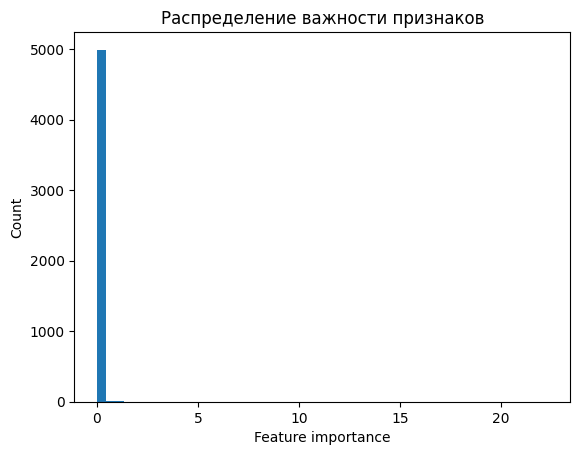

In [771]:
import numpy as np
import matplotlib.pyplot as plt


importances = clf.get_feature_importance()

plt.hist(importances, bins=50)
plt.xlabel("Feature importance")
plt.ylabel("Count")
plt.title("Распределение важности признаков")
plt.show()

In [ ]:



class_weights = {-1: 1.0, 0: 2.5, 1: 1.2}

text_col = "all_words"
num_cols = [
    "negative_counter", 
    "negative_ratio",
    "neutral_counter", 
    "neutral_ratio", 
    "positive_counter", 
    "positive_ratio",
    "sentiment_direction", 
    "sentiment_direction_normalized",
    'text_length', 
    'words_count', 
    'positive_negative_ratio',
    'sentiment_intensity'
]

X = df[[*num_cols, text_col]]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)


preprocessor = ColumnTransformer(transformers=[
    ("text_tfidf", TfidfVectorizer(
        ngram_range=(1, 3),
        min_df=3,
        max_df=0.8,
        max_features=5000,
        stop_words=russian_stopwords,
        sublinear_tf=True
    ), text_col),
    
    ("num_scaler", RobustScaler(), num_cols),
], remainder='drop') 


pipeline = Pipeline([
    ("preprocessor", preprocessor),
    
    ("feature_selector", SelectFromModel(
        CatBoostClassifier(
            iterations=150, 
            learning_rate=0.1,
            depth=8,
            random_state=42,
            verbose=0,
            class_weights=class_weights,
            loss_function="MultiClass",
            early_stopping_rounds=20,
            use_best_model=False
        ),
        threshold="median"
    )),
    

    ("clf", CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=8,
        random_state=42,
        verbose=100,
        class_weights=class_weights,
        loss_function="MultiClass",
        eval_metric="TotalF1",
        early_stopping_rounds=50,
        use_best_model=False,
        bootstrap_type='Bayesian',
        leaf_estimation_iterations=10,
        grow_policy='Lossguide'
    )),
])

In [756]:
X.columns

Index(['negative_counter', 'negative_ratio', 'neutral_counter',
       'neutral_ratio', 'positive_counter', 'positive_ratio',
       'sentiment_direction', 'sentiment_direction_normalized', 'text_length',
       'words_count', 'positive_negative_ratio', 'sentiment_intensity',
       'all_words'],
      dtype='object')

In [757]:
df.shape

(3657, 19)

In [769]:
pipeline.fit(
    X_train,
    y_train,
)


y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

0:	learn: 0.6274995	total: 40.9ms	remaining: 40.9s
100:	learn: 0.7497082	total: 3.86s	remaining: 34.4s
200:	learn: 0.8482611	total: 7.45s	remaining: 29.6s
300:	learn: 0.9407983	total: 11.5s	remaining: 26.6s
400:	learn: 0.9729420	total: 15.4s	remaining: 23s
500:	learn: 0.9889596	total: 19.3s	remaining: 19.3s
600:	learn: 0.9984226	total: 23.2s	remaining: 15.4s
700:	learn: 1.0000000	total: 27.2s	remaining: 11.6s
800:	learn: 1.0000000	total: 31.1s	remaining: 7.72s
900:	learn: 1.0000000	total: 34.8s	remaining: 3.83s
999:	learn: 1.0000000	total: 38.8s	remaining: 0us
              precision    recall  f1-score   support

          -1      0.859     0.909     0.884       484
           0      0.348     0.105     0.162        76
           1      0.816     0.873     0.844       355

    accuracy                          0.828       915
   macro avg      0.674     0.629     0.630       915
weighted avg      0.800     0.828     0.808       915

